# New York City 311 Service Requests

In this project, I will analyse which New York City boroughs have recieved the most incident service requests based on the agency involved. The dataset used is a subset from the 311 Service Requests from 2010 to Present dataset on the NYC Open Data website (https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

First, let's import our packages.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

Let's take a look at our data.

In [27]:
df = pd.read_csv("nyc_311_data_subset.csv")
df.head()

,Unique Key,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude
0,1,10/11/2016 11:53:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
1,1,10/11/2016 11:36:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
2,1,10/11/2016 11:36:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
3,1,10/11/2016 12:39:00 PM,10/11/2016 12:39:00 PM,DSNY,NaN,QUEENS,NaN,NaN
4,1,10/11/2016 12:18:00 PM,10/11/2016 12:18:00 PM,DSNY,NaN,QUEENS,NaN,NaN


In [4]:
df.info()
#comparing the number of entries to the non-null values in addition to the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971063 entries, 0 to 971062
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unique Key    971063 non-null  int64  
 1   Created Date  971063 non-null  object 
 2   Closed Date   882944 non-null  object 
 3   Agency        971063 non-null  object 
 4   Incident Zip  911140 non-null  object 
 5   Borough       971063 non-null  object 
 6   Latitude      887284 non-null  float64
 7   Longitude     887284 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 59.3+ MB


To get any statistical significance out of the data, we have to get rid of the null values in it.
Therefore, data cleaning is essential in better understanding our data.

## Data Cleaning

In this step, I noticed that the zip codes were not properly formatted: in strings, with more or less than five digits, or extremes. I dropped all rows with null values and unspecified boroughs. Using feature engineering, I created a new column to calculate the time it takes to complete a service request for each incident. I took all these and placed it inside a function that applys these data cleaning processes to the dataset.

In [5]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df

In [28]:
datafile = "nyc_311_data_subset.csv"
data = read_311_data(datafile)

In [7]:
data.head()

,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude,processing_time
Unique Key,,,,,,,,
1,2016-09-01 00:33:42,2016-09-16 01:06:56,DCA,10001,MANHATTAN,40.744790,-73.988834,15 days 00:33:14
1,2016-09-01 20:16:24,2016-09-10 18:08:25,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:01
1,2016-09-01 12:17:00,2016-09-07 12:00:00,DSNY,11211,BROOKLYN,40.704925,-73.962007,5 days 23:43:00
1,2016-09-01 12:10:22,2016-09-10 14:23:44,HPD,10027,MANHATTAN,40.812322,-73.955338,9 days 02:13:22
1,2016-09-01 12:32:32,2016-09-11 02:03:37,HPD,10452,BRONX,40.839529,-73.922534,9 days 13:31:05


## Incidents by Borough

Now that our data is cleaned, we can group the data by borough and plot a bar chart of incident count.

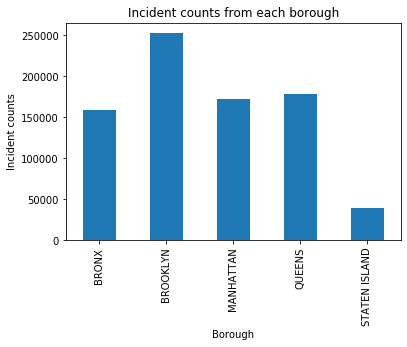

In [8]:
%matplotlib inline
borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')
#kind can be 'hist', 'scatter'
plt.ylabel('Incident counts')
plt.title('Incident counts from each borough')
plt.show()

As you can see Brooklyn has the highest incident counts around 250000 followed by Bronx, Manhattan, and Queens. 

## Incidents by Agency

To dive deeper, we can look at the incident counts across all the agencies.

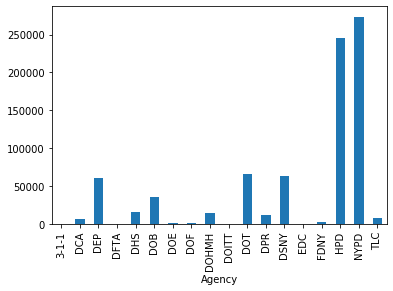

In [9]:
agency_group = data.groupby('Agency')
agency_group.size().plot(kind='bar')

The NYPD and the HPD both have the most service requests. 

## Incidents by Agency and Borough

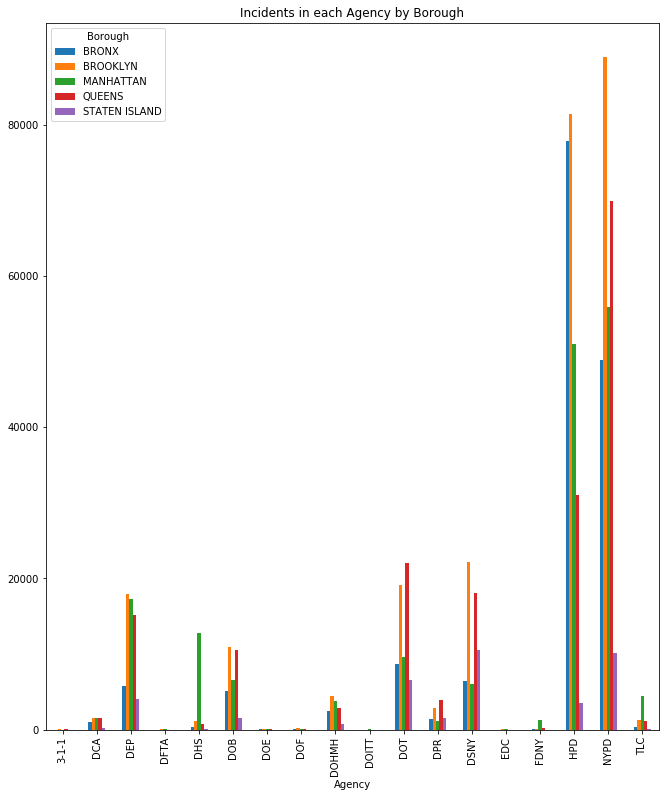

In [14]:
agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',title="Incidents in each Agency by Borough",figsize=(11,13))

Here we can see in depth which agencies were requested in each borough. Brooklyn had the most NYPD and HPD service request incidents. 

## Incidents by Time

We know the creation date of each incident so we can build a bar graph of number of incidents by month. This is not as useful for a few months of data but if we had all the data from 2010, we could use this sort of analysis to eyeball trends and seasonality. 

In [15]:
data['yyyymm'] = data['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))
#creating a new column with only year and months

In [17]:
data['yyyymm'].unique()

array(['201609', '201611', '201701', '201610', '201612'], dtype=object)

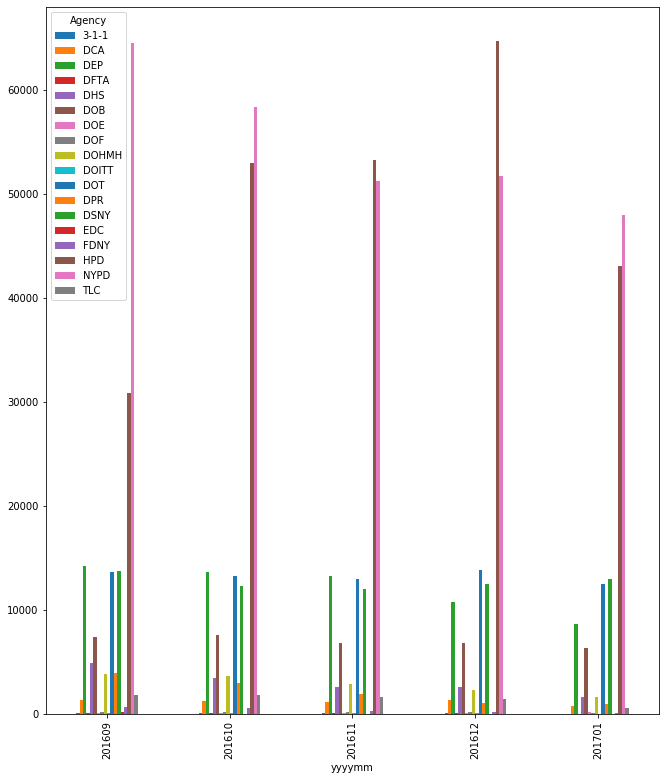

In [19]:
date_agency = data.groupby(['yyyymm','Agency'])
date_agency.size().unstack().plot(kind='bar',figsize=(11,13))

Housing Property Department service requests rose from September to December 2016. This could be due to the winter season and increased heating complaints.

I would suggest that the HPD invest resources in accommodating for the predicted increase in service requests around winter based on the data. 

## Request Processing Time

In [20]:
grouped = data[['processing_time','Borough']].groupby('Borough')

In [21]:
grouped.describe()

processing_time                                                 \
                        count                   mean                     std   
Borough                                                                        
BRONX                  158548 5 days 11:22:39.529133 10 days 19:29:45.763262   
BROOKLYN               252515 5 days 01:22:08.762913 11 days 20:44:39.914032   
MANHATTAN              171708 5 days 07:43:58.957480 12 days 01:57:03.858305   
QUEENS                 177641 4 days 22:17:46.753142 13 days 02:00:32.516708   
STATEN ISLAND           38911 5 days 00:57:16.541826 12 days 00:18:49.372858   

                                                             \
                 min             25%                    50%   
Borough                                                       
BRONX         0 days 05:48:38.250000        1 days 21:27:00   
BROOKLYN      0 days 02:33:20.500000        0 days 20:19:00   
MANHATTAN     0 days        02:03:43 0 days 22:13:02.500000   
QUEENS        0 days        02:07:59        0 days 10:15:11   
STATEN ISLAND 0 days        02:54:00        0 days 22:11:06   

                                                        
                                 75%               max  
Borough                                                 
BRONX         5 days 19:48:12.750000 145 days 00:23:57  
BROOKLYN             4 days 05:20:01 146 days 17:26:50  
MANHATTAN     4 days 11:06:08.500000 139 days 22:41:59  
QUEENS               3 days 20:47:00 148 days 13:10:54  
STATEN ISLAND        4 days 15:24:28 139 days 22:06:35

The avergae processing time for each borough was roughly five days, but according to this table most of Queens' requests were resolved rather quickly. 

In [22]:
import numpy as np
#The time it takes to process. Cleaned up
data['float_time'] =data['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [23]:
data

,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude,processing_time,yyyymm,float_time
Unique Key,,,,,,,,,,
1,2016-09-01 00:33:42,2016-09-16 01:06:56,DCA,10001,MANHATTAN,40.744790,-73.988834,15 days 00:33:14,201609,15.023079
1,2016-09-01 20:16:24,2016-09-10 18:08:25,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:01,201609,8.911123
1,2016-09-01 12:17:00,2016-09-07 12:00:00,DSNY,11211,BROOKLYN,40.704925,-73.962007,5 days 23:43:00,201609,5.988194
1,2016-09-01 12:10:22,2016-09-10 14:23:44,HPD,10027,MANHATTAN,40.812322,-73.955338,9 days 02:13:22,201609,9.092616
1,2016-09-01 12:32:32,2016-09-11 02:03:37,HPD,10452,BRONX,40.839529,-73.922534,9 days 13:31:05,201609,9.563252
...,...,...,...,...,...,...,...,...,...,...
1,2016-09-20 15:02:25,2016-09-24 09:33:13,HPD,10469,BRONX,40.877527,-73.847712,3 days 18:30:48,201609,3.771389
1,2016-09-20 11:36:47,2016-10-21 20:02:42,HPD,10029,MANHATTAN,40.791709,-73.937064,31 days 08:25:55,201609,31.351331
1,2016-09-20 16:41:40,2016-09-24 09:41:28,HPD,10460,BRONX,40.833706,-73.895943,3 days 16:59:48,201609,3.708194


In [25]:
grouped = data[['float_time','Agency']].groupby('Agency')
grouped.mean().sort_values('float_time',ascending=True)

,float_time
Agency,
3-1-1,0.016513
NYPD,0.205126
DHS,0.207951
DOF,2.728715
DSNY,3.052327
DEP,3.520583
DOT,4.447129
DFTA,8.465869
HPD,8.799452


Although having the most service requests, HPD and NYPD had among the quickest processing times.

## Conclusion

From the data provided, Brooklyn had the most incident service request compared to the other boroughs. Additionaly, all of the boroughs had mostly service requests from the HPD and NYPD. Despite this massive amount of incident requests, both the HPD and the NYPD were the top three agencies with fast processing times. 

Github :https://github.com/gabriel-olufade/

LinkedIn: https://www.linkedin.com/in/gabrielolufade/